### Import required Packages and gathering Data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [9]:
crop_df = pd.read_excel("Crop_data.xlsx", sheet_name="Sheet1")
crop_yield_df = pd.read_csv("D:/All_Projects/splitmindz/Crop_Yield_Prediction.csv")
# concat_df = pd.concat([crop_df, crop_yield_df], axis = 1)


In [10]:
crop_df.columns

Index(['State', 'District', 'Crop', 'Current_price', 'Stage',
       'Preparation_Activity', 'Sowing_Date', 'Fertilization', 'Irrigation',
       'Area (in hectares)', 'Required Production per Year'],
      dtype='object')

In [11]:
crop_df.isnull().sum()

State                             0
District                          0
Crop                              0
Current_price                     0
Stage                             0
Preparation_Activity              0
Sowing_Date                       0
Fertilization                    66
Irrigation                      132
Area (in hectares)                0
Required Production per Year      0
dtype: int64

### Anaysis and Preprocessing

#### Analysis

In [12]:
crop_df.shape

(132, 11)

In [13]:
crop_df.head()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Sowing_Date,Fertilization,Irrigation,Area (in hectares),Required Production per Year
0,Maharashtra,Ahmednagar,Ragi,28.39,Preparation,Plowing,2024-01-15,Tillage,NaN,100,6129.856
1,Maharashtra,Ahmednagar,Ragi,25.71,Preparation,Weeding,2024-01-20,NaN,NaN,100,5446.704
2,Maharashtra,Ahmednagar,Ragi,27.05,Preparation,Fertilizer application,2024-01-25,Organic manure,NaN,100,5985.228
3,Maharashtra,Ahmednagar,Ragi,34.08,Preparation,Seed selection,2024-01-30,NaN,NaN,100,5886.888
4,Maharashtra,Pune,Ragi,29.76,Preparation,Plowing,2024-01-20,Tillage,NaN,150,7170.876


In [14]:
crop_df.tail()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Sowing_Date,Fertilization,Irrigation,Area (in hectares),Required Production per Year
127,Madhya Pradesh,Jabalpur,Maize,33.17,Preparation,Seed selection,2024-02-10,NaN,NaN,300,6220.368
128,Madhya Pradesh,Gwalior,Maize,30.42,Preparation,Plowing,2024-01-20,Tillage,NaN,350,5451.144
129,Madhya Pradesh,Gwalior,Maize,31.81,Preparation,Weeding,2024-01-25,NaN,NaN,350,6383.148
130,Madhya Pradesh,Gwalior,Maize,32.67,Preparation,Fertilizer application,2024-01-30,Organic manure,NaN,350,6325.464
131,Madhya Pradesh,Gwalior,Maize,29.79,Preparation,Seed selection,2024-02-05,NaN,NaN,350,6001.548


In [15]:
crop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   State                         132 non-null    object        
 1   District                      132 non-null    object        
 2   Crop                          132 non-null    object        
 3   Current_price                 132 non-null    float64       
 4   Stage                         132 non-null    object        
 5   Preparation_Activity          132 non-null    object        
 6   Sowing_Date                   132 non-null    datetime64[ns]
 7   Fertilization                 66 non-null     object        
 8   Irrigation                    0 non-null      float64       
 9   Area (in hectares)            132 non-null    int64         
 10  Required Production per Year  132 non-null    float64       
dtypes: datetime64[ns](1), float64(3)

In [16]:
crop_df["Crop"].value_counts()

Crop
Wheat        24
Ragi         16
Onion        16
Rice         16
Tomato       12
Sorghum       8
Barley        8
Groundnut     8
Cotton        8
Soybean       8
Maize         8
Name: count, dtype: int64

In [17]:
crop_df.describe(include="O")

,State,District,Crop,Stage,Preparation_Activity,Fertilization
count,132,132,132,132,132,66
unique,8,33,11,1,4,2
top,Maharashtra,Ahmednagar,Wheat,Preparation,Plowing,Tillage
freq,20,4,24,132,33,33


In [18]:
crop_df.describe()

,Current_price,Sowing_Date,Irrigation,Area (in hectares),Required Production per Year
count,132.000000,132,0.0,132.000000,132.000000
mean,30.430606,2024-05-15 10:54:32.727272704,NaN,254.545455,6073.584152
min,25.610000,2024-01-15 00:00:00,NaN,100.000000,4736.808000
25%,29.035000,2024-02-04 00:00:00,NaN,200.000000,5700.297000
50%,30.425000,2024-02-27 12:00:00,NaN,250.000000,6048.282000
75%,31.912500,2024-10-20 00:00:00,NaN,300.000000,6405.942000
max,34.670000,2024-11-05 00:00:00,NaN,350.000000,7357.548000
std,1.956230,NaN,NaN,68.085752,567.756690


#### Handling Missing values

In [19]:
crop_data = crop_df.copy()

In [20]:
crop_data.isna().sum()

State                             0
District                          0
Crop                              0
Current_price                     0
Stage                             0
Preparation_Activity              0
Sowing_Date                       0
Fertilization                    66
Irrigation                      132
Area (in hectares)                0
Required Production per Year      0
dtype: int64

In [21]:
crop_data["Fertilization"].value_counts()

Fertilization
Tillage           33
Organic manure    33
Name: count, dtype: int64

In [22]:
crop_data["Irrigation"].value_counts()

Series([], Name: count, dtype: int64)

In [23]:
crop_data["Preparation_Activity"].value_counts()

Preparation_Activity
Plowing                   33
Weeding                   33
Fertilizer application    33
Seed selection            33
Name: count, dtype: int64

In [24]:
crop_data["Crop"].value_counts()

Crop
Wheat        24
Ragi         16
Onion        16
Rice         16
Tomato       12
Sorghum       8
Barley        8
Groundnut     8
Cotton        8
Soybean       8
Maize         8
Name: count, dtype: int64

In [25]:
# crop_data.to_csv("merged_crop_df.csv")

In [26]:
# Define irrigation rules based on crop type and sowing season
def determine_irrigation(row):
    crop = row['Crop']
    if crop == 'Rice':
        return 'Flood'
    elif crop in ['Wheat', 'Barley', 'Ragi', 'Sorghum', 'Groundnut', 'Soybean', 'Maize']:
        return 'Sprinkler'
    elif crop in ['Tomato', 'Onion', 'Cotton']:
        return 'Drip'
    else:
        return 'None'

In [27]:
# Apply the function to create the 'Irrigation' feature
crop_data['Irrigation'] = crop_data.apply(determine_irrigation, axis=1)

In [28]:
crop_data["Irrigation"].value_counts()

Irrigation
Sprinkler    80
Drip         36
Flood        16
Name: count, dtype: int64

In [29]:
crop_data.isnull().sum()

State                            0
District                         0
Crop                             0
Current_price                    0
Stage                            0
Preparation_Activity             0
Sowing_Date                      0
Fertilization                   66
Irrigation                       0
Area (in hectares)               0
Required Production per Year     0
dtype: int64

In [30]:
crop_data.ffill(inplace=True)

In [31]:
crop_data.isnull().sum()

State                           0
District                        0
Crop                            0
Current_price                   0
Stage                           0
Preparation_Activity            0
Sowing_Date                     0
Fertilization                   0
Irrigation                      0
Area (in hectares)              0
Required Production per Year    0
dtype: int64

In [32]:
crop_data.head()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Sowing_Date,Fertilization,Irrigation,Area (in hectares),Required Production per Year
0,Maharashtra,Ahmednagar,Ragi,28.39,Preparation,Plowing,2024-01-15,Tillage,Sprinkler,100,6129.856
1,Maharashtra,Ahmednagar,Ragi,25.71,Preparation,Weeding,2024-01-20,Tillage,Sprinkler,100,5446.704
2,Maharashtra,Ahmednagar,Ragi,27.05,Preparation,Fertilizer application,2024-01-25,Organic manure,Sprinkler,100,5985.228
3,Maharashtra,Ahmednagar,Ragi,34.08,Preparation,Seed selection,2024-01-30,Organic manure,Sprinkler,100,5886.888
4,Maharashtra,Pune,Ragi,29.76,Preparation,Plowing,2024-01-20,Tillage,Sprinkler,150,7170.876


In [33]:
crop_data["Fertilization"].value_counts()

Fertilization
Tillage           66
Organic manure    66
Name: count, dtype: int64

In [34]:
handle_missing_crop_data = crop_data.copy()

#### Feature Engineering

In [35]:
handle_missing_crop_data.head(2)

,State,District,Crop,Current_price,Stage,Preparation_Activity,Sowing_Date,Fertilization,Irrigation,Area (in hectares),Required Production per Year
0,Maharashtra,Ahmednagar,Ragi,28.39,Preparation,Plowing,2024-01-15,Tillage,Sprinkler,100,6129.856
1,Maharashtra,Ahmednagar,Ragi,25.71,Preparation,Weeding,2024-01-20,Tillage,Sprinkler,100,5446.704


In [37]:
weather_data = pd.DataFrame({
    "Humidity":np.random.uniform(15, 100, len(crop_df)),
    "pH_Value": np.random.uniform(3, 10, len(crop_df)),
    'temperature': np.random.uniform(8, 45, len(crop_df)),  # Random temperatures between 20 and 35 degrees Celsius
    'rainfall': np.random.uniform(20, 300, len(crop_df))      # Random rainfall between 0 and 20 mm
})

# Generate synthetic market trend data
market_data = pd.DataFrame({
    'demand_index': np.random.uniform(80, 150, len(crop_df)),  # Random demand index between 80 and 150
    'supply_index': np.random.uniform(90, 120, len(crop_df))   # Random supply index between 90 and 120
})


In [38]:
weather_data.describe()

,Humidity,pH_Value,temperature,rainfall
count,132.000000,132.000000,132.000000,132.000000
mean,55.448606,6.630614,27.505200,169.949211
std,24.502989,2.062010,11.100178,76.120507
min,15.380463,3.051306,8.182089,21.091675
25%,33.857702,4.815175,17.187790,107.234410
50%,56.268038,6.914366,28.352027,169.428809
75%,77.002076,8.418121,37.465973,236.966461
max,98.373841,9.943850,44.656114,298.825340


In [39]:
market_data.describe()

,demand_index,supply_index
count,132.000000,132.000000
mean,117.208715,105.524978
std,19.005611,9.082133
min,80.775629,90.426097
25%,103.678195,97.014991
50%,119.329267,106.506535
75%,133.540835,112.932699
max,149.764605,119.973424


In [40]:
concated_data = pd.concat([handle_missing_crop_data, weather_data, market_data], axis = 1)
concated_data.head()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Sowing_Date,Fertilization,Irrigation,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index
0,Maharashtra,Ahmednagar,Ragi,28.39,Preparation,Plowing,2024-01-15,Tillage,Sprinkler,100,6129.856,37.388607,7.232397,40.497180,37.145388,143.154688,115.459460
1,Maharashtra,Ahmednagar,Ragi,25.71,Preparation,Weeding,2024-01-20,Tillage,Sprinkler,100,5446.704,98.373841,9.505618,26.459027,215.812249,88.676956,102.869961
2,Maharashtra,Ahmednagar,Ragi,27.05,Preparation,Fertilizer application,2024-01-25,Organic manure,Sprinkler,100,5985.228,63.097503,8.116060,29.656478,261.361684,119.418497,93.063790
3,Maharashtra,Ahmednagar,Ragi,34.08,Preparation,Seed selection,2024-01-30,Organic manure,Sprinkler,100,5886.888,98.014351,5.121559,40.611990,266.722433,123.535019,111.168592
4,Maharashtra,Pune,Ragi,29.76,Preparation,Plowing,2024-01-20,Tillage,Sprinkler,150,7170.876,72.700548,7.212241,24.767702,99.375645,127.098627,113.166541


In [41]:
# Date Feature Engineering
concated_data['Sowing_Date'] = pd.to_datetime(concated_data['Sowing_Date'], errors='coerce')
concated_data['Sowing_Month'] = concated_data['Sowing_Date'].dt.month
concated_data['Sowing_Season'] = concated_data['Sowing_Date'].dt.quarter
concated_data['Days_Since_Sowing'] = (datetime.now() - concated_data['Sowing_Date']).dt.days

In [42]:
# Drop original Sowing_Date as we have extracted useful features
concated_data.drop(columns=['Sowing_Date'], inplace=True)

In [116]:
concated_data.columns

Index(['State', 'District', 'Crop', 'Current_price', 'Stage',
       'Preparation_Activity', 'Fertilization', 'Irrigation',
       'Area (in hectares)', 'Required Production per Year', 'Humidity',
       'pH_Value', 'temperature', 'rainfall', 'demand_index', 'supply_index',
       'Sowing_Month', 'Sowing_Season', 'Days_Since_Sowing'],
      dtype='object')

In [117]:
renamed_features_data = concated_data.rename({"Area (in hectares)":"Area_in_hectares", "Required Production per Year":'Required_Production_per_Year'}, axis = 1)

In [118]:
categorical_features = ['State', 'District', 'Stage', 'Crop', 'Preparation_Activity', 'Fertilization', 'Irrigation']
numerical_features = ['Current_price','Area_in_hectares', 'Required_Production_per_Year', 'Humidity', 'pH_Value', 'temperature', 'rainfall', 
                      'demand_index', 'supply_index', 'Sowing_Month', 'Sowing_Season', 'Days_Since_Sowing']
crop_summary = pd.pivot_table(renamed_features_data[numerical_features], index = renamed_features_data["Crop"], aggfunc="mean")
crop_summary.reset_index()

,Crop,Area_in_hectares,Current_price,Days_Since_Sowing,Humidity,Required_Production_per_Year,Sowing_Month,Sowing_Season,demand_index,pH_Value,rainfall,supply_index,temperature
0,Barley,325.000000,30.766250,-57.125,51.930649,6094.879500,10.1250,4.0000,124.163858,6.630856,124.303182,103.443918,34.586815
1,Cotton,325.000000,30.511250,206.125,56.264497,6213.585000,1.7500,1.0000,118.047331,7.218319,166.612255,102.463448,31.076893
2,Groundnut,225.000000,30.107500,216.875,68.030204,6107.410500,1.1250,1.0000,125.153548,6.614405,162.921500,102.722858,23.316470
3,Maize,325.000000,31.055000,211.625,52.373191,6106.380000,1.3750,1.0000,123.889779,4.945973,160.397341,105.463890,28.554364
4,Onion,225.000000,30.419375,-57.125,56.880189,5881.728000,10.1250,4.0000,117.504427,6.678079,178.206761,107.521797,22.404005
5,Ragi,175.000000,29.840000,186.875,69.886298,6053.216500,2.1250,1.0625,119.578737,7.183061,198.515138,107.210349,29.901042
6,Rice,225.000000,30.186250,193.500,52.957232,6084.391500,2.1875,1.0000,118.283051,6.636619,164.820112,105.193796,26.933928
7,Sorghum,225.000000,31.146250,206.125,51.371095,5941.108500,1.7500,1.0000,107.086992,5.865515,196.976895,104.196302,27.905278
8,Soybean,225.000000,30.343750,186.125,46.423371,5960.797500,2.3750,1.0000,121.612369,7.491249,198.123834,109.258064,22.096066
9,Tomato,216.666667,30.346667,197.750,44.190460,6228.097000,1.7500,1.0000,115.833072,7.064013,141.504413,107.309336,26.233649


In [119]:
renamed_features_data["Sowing_Season"].value_counts()

Sowing_Season
1    83
4    48
2     1
Name: count, dtype: int64

In [76]:
renamed_features_data.head()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Fertilization,Irrigation,Area_in_hectares,Required_Production_per_Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index,Sowing_Month,Sowing_Season,Days_Since_Sowing
0,Maharashtra,Ahmednagar,Ragi,28.39,Preparation,Plowing,Tillage,Sprinkler,100,6129.856,37.388607,7.232397,40.497180,37.145388,143.154688,115.459460,1,1,227
1,Maharashtra,Ahmednagar,Ragi,25.71,Preparation,Weeding,Tillage,Sprinkler,100,5446.704,98.373841,9.505618,26.459027,215.812249,88.676956,102.869961,1,1,222
2,Maharashtra,Ahmednagar,Ragi,27.05,Preparation,Fertilizer application,Organic manure,Sprinkler,100,5985.228,63.097503,8.116060,29.656478,261.361684,119.418497,93.063790,1,1,217
3,Maharashtra,Ahmednagar,Ragi,34.08,Preparation,Seed selection,Organic manure,Sprinkler,100,5886.888,98.014351,5.121559,40.611990,266.722433,123.535019,111.168592,1,1,212
4,Maharashtra,Pune,Ragi,29.76,Preparation,Plowing,Tillage,Sprinkler,150,7170.876,72.700548,7.212241,24.767702,99.375645,127.098627,113.166541,1,1,222


#### Handling Outliers

In [77]:
renamed_features_data.describe()

,Current_price,Area_in_hectares,Required_Production_per_Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index,Sowing_Month,Sowing_Season,Days_Since_Sowing
count,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,30.430606,254.545455,6073.584152,55.448606,6.630614,27.505200,169.949211,117.208715,105.524978,4.871212,2.098485,105.545455
std,1.956230,68.085752,567.756690,24.502989,2.062010,11.100178,76.120507,19.005611,9.082133,4.038754,1.445498,124.605721
min,25.610000,100.000000,4736.808000,15.380463,3.051306,8.182089,21.091675,80.775629,90.426097,1.000000,1.000000,-68.000000
25%,29.035000,200.000000,5700.297000,33.857702,4.815175,17.187790,107.234410,103.678195,97.014991,2.000000,1.000000,-52.000000
50%,30.425000,250.000000,6048.282000,56.268038,6.914366,28.352027,169.428809,119.329267,106.506535,2.500000,1.000000,183.500000
75%,31.912500,300.000000,6405.942000,77.002076,8.418121,37.465973,236.966461,133.540835,112.932699,10.000000,4.000000,207.000000
max,34.670000,350.000000,7357.548000,98.373841,9.943850,44.656114,298.825340,149.764605,119.973424,11.000000,4.000000,227.000000


In [78]:
def detect_outliers(df):
    l = []
    for i in df.columns:
        if df[i].dtypes != "O":
            Q1 = np.percentile(df[i], 25)
            Q3 = np.percentile(df[i], 75)
            IQR = Q3-Q1
            Quartile_dev = (Q3-Q1)/2
            up = Q3 + 1.5*IQR
            lb = Q1 - 1.5*IQR
            std = df[i].std()
            l.append([np.round(j, 2) for j in [Q1, Q3, IQR, Quartile_dev, up, lb, std]])
            get_outlier = df[(df[i]<lb) | (df[i]>up)]
    return get_outlier

In [87]:
detect_outliers(renamed_features_data)
print("There is no Outliers in the Crop dataset with calculation")

There is no Outliers in the Crop dataset with calculation


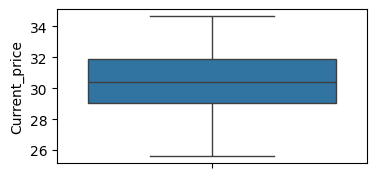

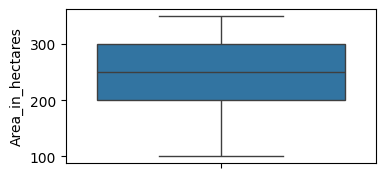

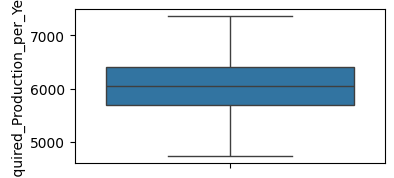

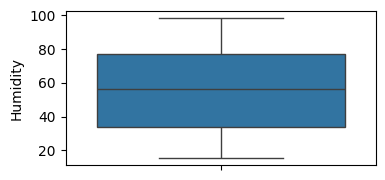

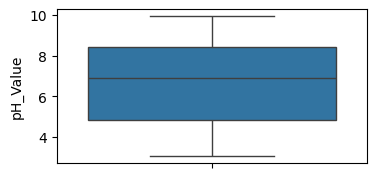

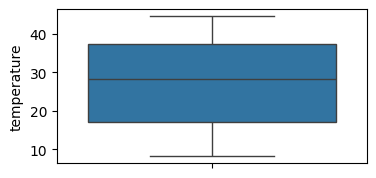

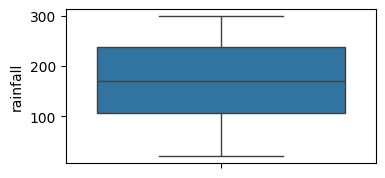

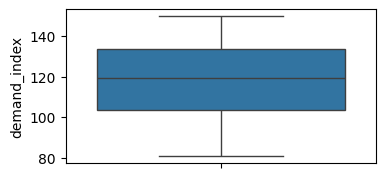

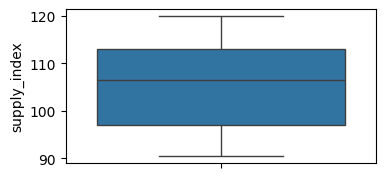

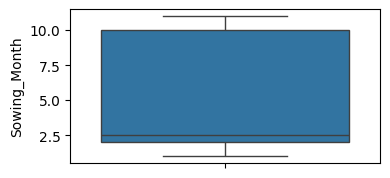

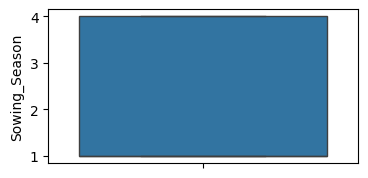

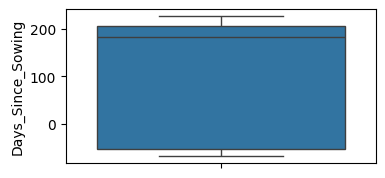

Identified no outliers in dataset using Boxplot Visualization 


In [88]:
for i in renamed_features_data.columns:
      if renamed_features_data[i].dtypes != "O":
        plt.figure(figsize=(4,2))
        sns.boxplot(renamed_features_data[i])
        plt.show()

print("Identified no outliers in dataset using Boxplot Visualization ")

Identified Anamolies in the dataset features called 'Days_Since_Sowing'


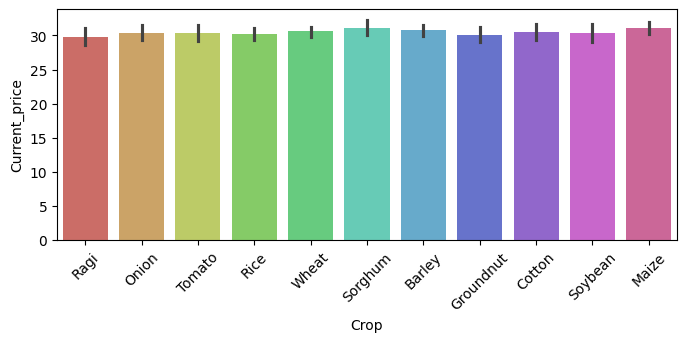

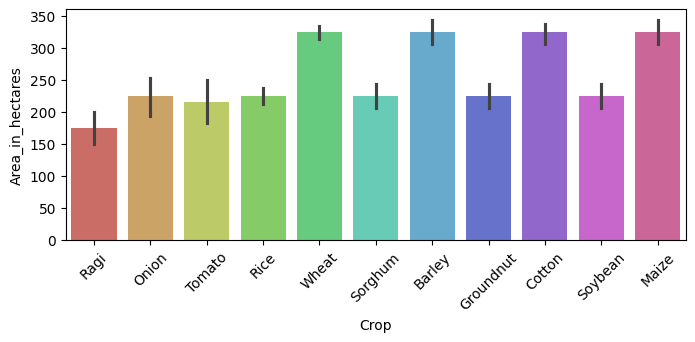

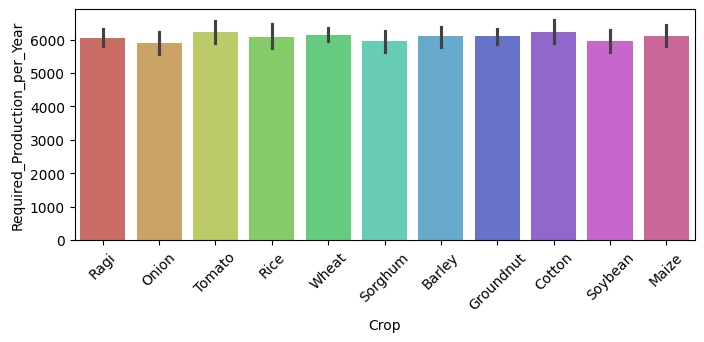

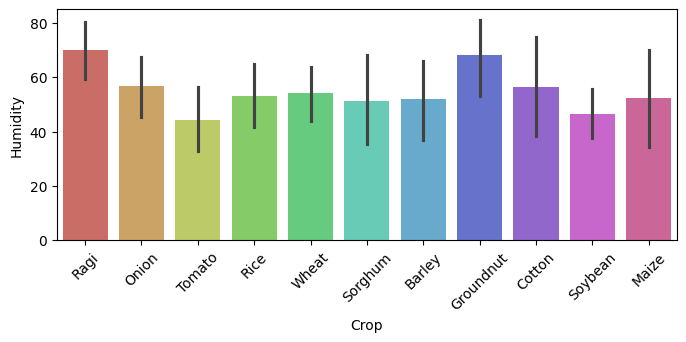

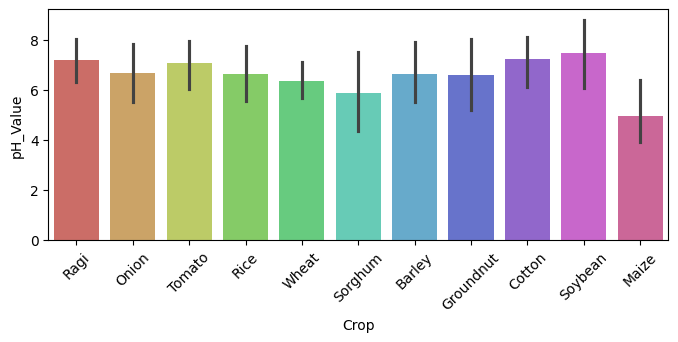

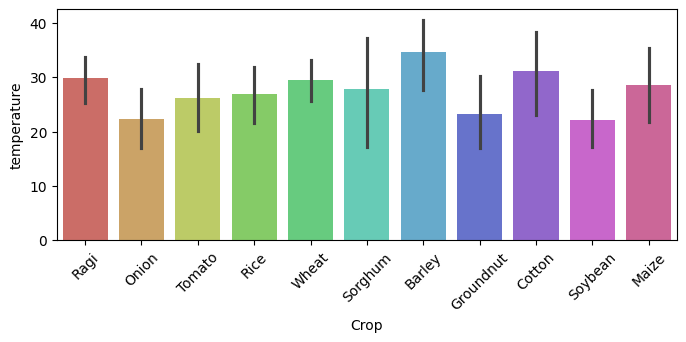

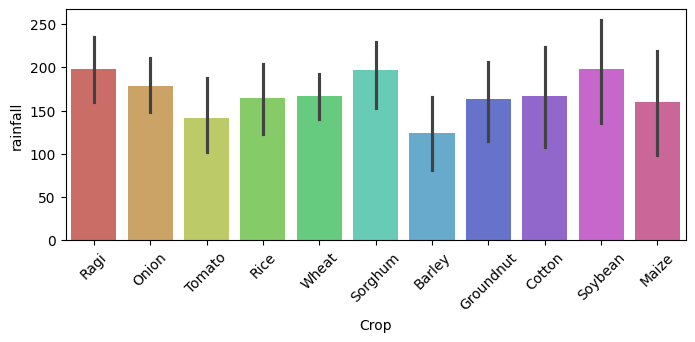

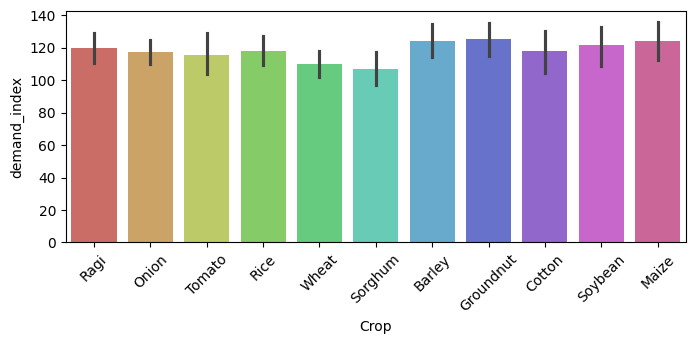

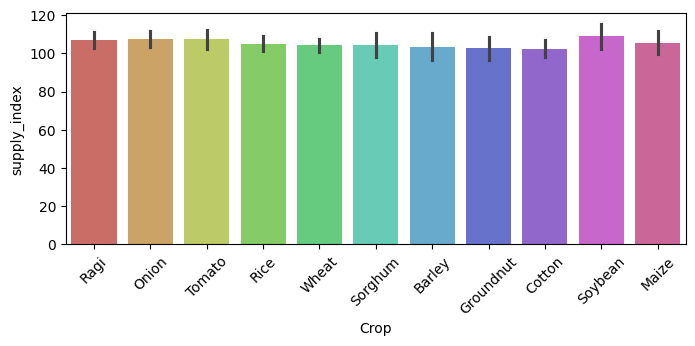

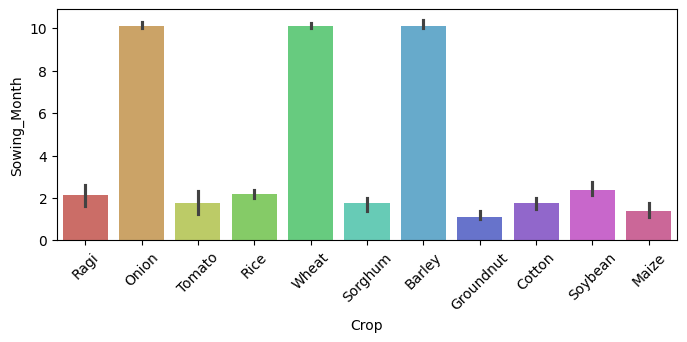

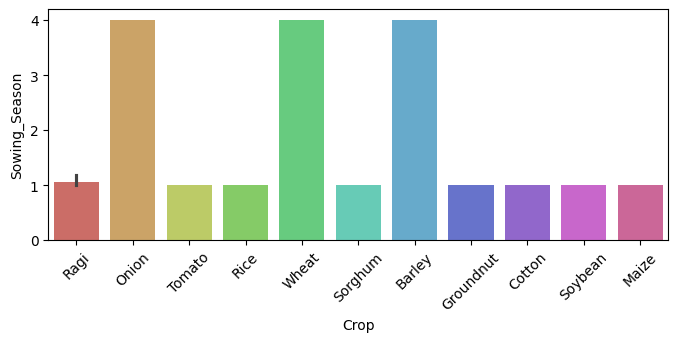

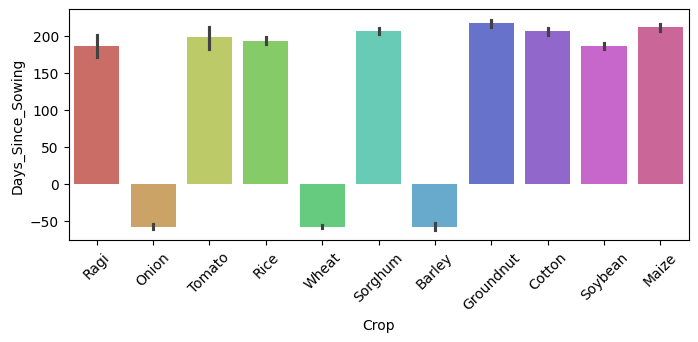

In [89]:
for i in renamed_features_data[numerical_features].columns:
    plt.figure(figsize=(8,3))
    sns.barplot(x = "Crop", y = i, data=renamed_features_data, palette='hls')
    plt.xticks(rotation = 45)

print("Identified Anamolies in the dataset features called 'Days_Since_Sowing'")

Identifying Anamolies in the dataset which reduces the model performance

In [91]:
# renamed_features_data[renamed_features_data["Days_Since_Sowing"]<0]
renamed_features_data["Days_Since_Sowing"] = renamed_features_data["Days_Since_Sowing"].abs()
renamed_features_data[renamed_features_data["Days_Since_Sowing"]<0]

,State,District,Crop,Current_price,Stage,Preparation_Activity,Fertilization,Irrigation,Area_in_hectares,Required_Production_per_Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index,Sowing_Month,Sowing_Season,Days_Since_Sowing


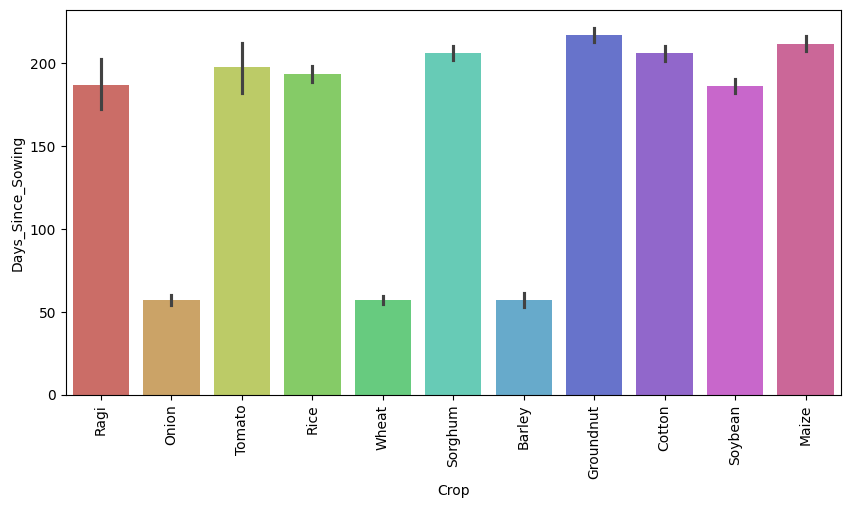

In [92]:
plt.figure(figsize=(10,5))
sns.barplot(x = "Crop", y = "Days_Since_Sowing", data=renamed_features_data, palette='hls')
plt.xticks(rotation = 90)
plt.show()

In [99]:
anomaly_crop_data = renamed_features_data.copy()

#### Encoding categorical features

In [100]:
anomaly_crop_data.dtypes

State                            object
District                         object
Crop                             object
Current_price                   float64
Stage                            object
Preparation_Activity             object
Fertilization                    object
Irrigation                       object
Area_in_hectares                  int64
Required_Production_per_Year    float64
Humidity                        float64
pH_Value                        float64
temperature                     float64
rainfall                        float64
demand_index                    float64
supply_index                    float64
Sowing_Month                      int32
Sowing_Season                     int32
Days_Since_Sowing                 int64
dtype: object

Encoding the all categorical features into numerical form using LabelEncoding() method which is replace the categorical values into numerical values

In [101]:
le = LabelEncoder()
for i in anomaly_crop_data[categorical_features]:
    anomaly_crop_data[i] = le.fit_transform(anomaly_crop_data[i])


In [102]:
encoded_crop_data = anomaly_crop_data.copy()

In [103]:
encoded_crop_data.dtypes

State                             int32
District                          int32
Crop                              int32
Current_price                   float64
Stage                             int32
Preparation_Activity              int32
Fertilization                     int32
Irrigation                        int32
Area_in_hectares                  int64
Required_Production_per_Year    float64
Humidity                        float64
pH_Value                        float64
temperature                     float64
rainfall                        float64
demand_index                    float64
supply_index                    float64
Sowing_Month                      int32
Sowing_Season                     int32
Days_Since_Sowing                 int64
dtype: object

In [104]:
encoded_crop_data.head()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Fertilization,Irrigation,Area_in_hectares,Required_Production_per_Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index,Sowing_Month,Sowing_Season,Days_Since_Sowing
0,3,2,5,28.39,0,1,1,2,100,6129.856,37.388607,7.232397,40.497180,37.145388,143.154688,115.459460,1,1,227
1,3,2,5,25.71,0,3,1,2,100,5446.704,98.373841,9.505618,26.459027,215.812249,88.676956,102.869961,1,1,222
2,3,2,5,27.05,0,0,0,2,100,5985.228,63.097503,8.116060,29.656478,261.361684,119.418497,93.063790,1,1,217
3,3,2,5,34.08,0,2,0,2,100,5886.888,98.014351,5.121559,40.611990,266.722433,123.535019,111.168592,1,1,212
4,3,25,5,29.76,0,1,1,2,150,7170.876,72.700548,7.212241,24.767702,99.375645,127.098627,113.166541,1,1,222


In [105]:
encoded_crop_data.describe()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Fertilization,Irrigation,Area_in_hectares,Required_Production_per_Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index,Sowing_Month,Sowing_Season,Days_Since_Sowing
count,132.000000,132.000000,132.000000,132.000000,132.0,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,3.484848,16.000000,5.727273,30.430606,0.0,1.500000,0.500000,1.333333,254.545455,6073.584152,55.448606,6.630614,27.505200,169.949211,117.208715,105.524978,4.871212,2.098485,147.090909
std,2.266533,9.558179,3.138266,1.956230,0.0,1.122293,0.501905,0.879509,68.085752,567.756690,24.502989,2.062010,11.100178,76.120507,19.005611,9.082133,4.038754,1.445498,70.360300
min,0.000000,0.000000,0.000000,25.610000,0.0,0.000000,0.000000,0.000000,100.000000,4736.808000,15.380463,3.051306,8.182089,21.091675,80.775629,90.426097,1.000000,1.000000,47.000000
25%,2.000000,8.000000,4.000000,29.035000,0.0,0.750000,0.000000,0.000000,200.000000,5700.297000,33.857702,4.815175,17.187790,107.234410,103.678195,97.014991,2.000000,1.000000,62.000000
50%,3.000000,16.000000,6.000000,30.425000,0.0,1.500000,0.500000,2.000000,250.000000,6048.282000,56.268038,6.914366,28.352027,169.428809,119.329267,106.506535,2.500000,1.000000,183.500000
75%,5.000000,24.000000,9.000000,31.912500,0.0,2.250000,1.000000,2.000000,300.000000,6405.942000,77.002076,8.418121,37.465973,236.966461,133.540835,112.932699,10.000000,4.000000,207.000000
max,7.000000,32.000000,10.000000,34.670000,0.0,3.000000,1.000000,2.000000,350.000000,7357.548000,98.373841,9.943850,44.656114,298.825340,149.764605,119.973424,11.000000,4.000000,227.000000


#### Correlation Matrixs

In [106]:
encoded_crop_data.dtypes

State                             int32
District                          int32
Crop                              int32
Current_price                   float64
Stage                             int32
Preparation_Activity              int32
Fertilization                     int32
Irrigation                        int32
Area_in_hectares                  int64
Required_Production_per_Year    float64
Humidity                        float64
pH_Value                        float64
temperature                     float64
rainfall                        float64
demand_index                    float64
supply_index                    float64
Sowing_Month                      int32
Sowing_Season                     int32
Days_Since_Sowing                 int64
dtype: object

In [112]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interaction_features = poly.fit_transform(encoded_crop_data[['Crop', 'Sowing_Season']])


In [120]:
poly.get_feature_names_out(["Crop","Sowing_Season"])

array(['Crop', 'Sowing_Season', 'Crop Sowing_Season'], dtype=object)

In [122]:

interaction_data = pd.DataFrame(interaction_features, columns = poly.get_feature_names_out(["Crop","Sowing_Season"]))
concat_crop = pd.concat([encoded_crop_data, interaction_data], axis = 1)
remove_duplicate_crop_df = concat_crop.loc[:, ~concat_crop.columns.duplicated()]
remove_duplicate_crop_df.head()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Fertilization,Irrigation,Area_in_hectares,Required_Production_per_Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index,Sowing_Month,Sowing_Season,Days_Since_Sowing,Crop Sowing_Season
0,3,2,5,28.39,0,1,1,2,100,6129.856,37.388607,7.232397,40.497180,37.145388,143.154688,115.459460,1,1,227,5.0
1,3,2,5,25.71,0,3,1,2,100,5446.704,98.373841,9.505618,26.459027,215.812249,88.676956,102.869961,1,1,222,5.0
2,3,2,5,27.05,0,0,0,2,100,5985.228,63.097503,8.116060,29.656478,261.361684,119.418497,93.063790,1,1,217,5.0
3,3,2,5,34.08,0,2,0,2,100,5886.888,98.014351,5.121559,40.611990,266.722433,123.535019,111.168592,1,1,212,5.0
4,3,25,5,29.76,0,1,1,2,150,7170.876,72.700548,7.212241,24.767702,99.375645,127.098627,113.166541,1,1,222,5.0


In [123]:
remove_duplicate_crop_df.drop(["Crop","Sowing_Season"], axis = 1, inplace=True)

In [124]:
remove_duplicate_crop_df.head(2)

,State,District,Current_price,Stage,Preparation_Activity,Fertilization,Irrigation,Area_in_hectares,Required_Production_per_Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index,Sowing_Month,Days_Since_Sowing,Crop Sowing_Season
0,3,2,28.39,0,1,1,2,100,6129.856,37.388607,7.232397,40.497180,37.145388,143.154688,115.459460,1,227,5.0
1,3,2,25.71,0,3,1,2,100,5446.704,98.373841,9.505618,26.459027,215.812249,88.676956,102.869961,1,222,5.0


In [129]:
crop_corr_df = remove_duplicate_crop_df.corr()

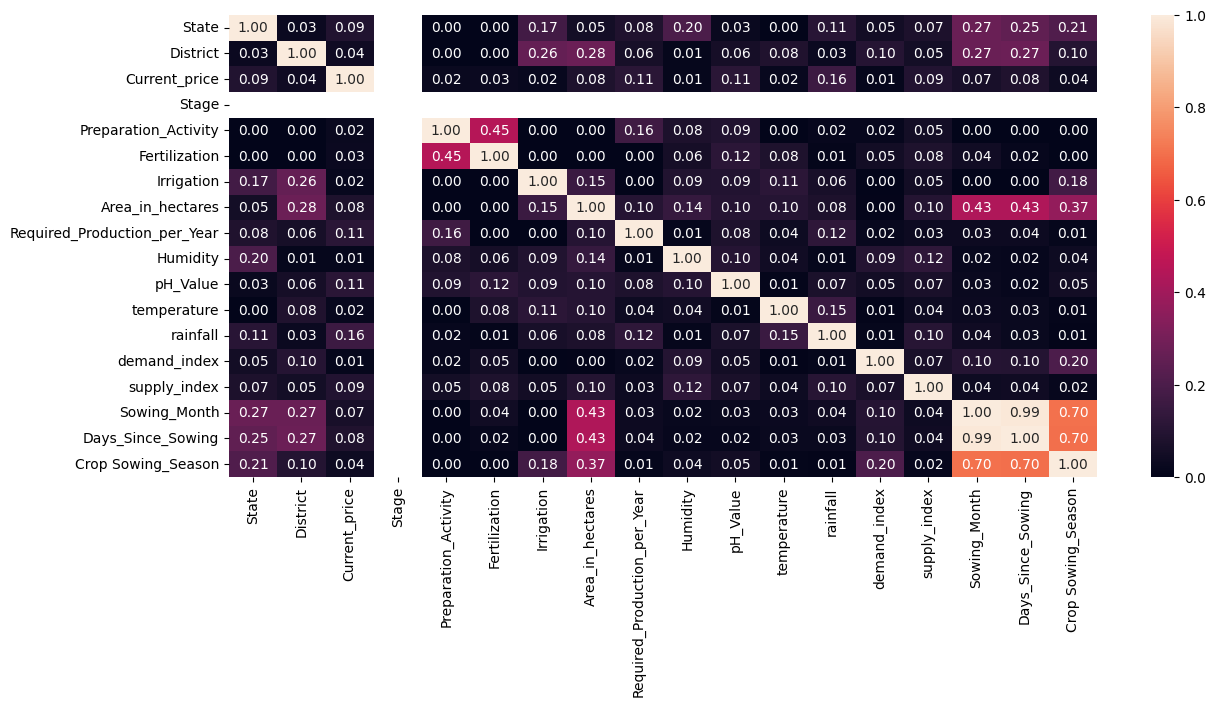

In [130]:
plt.figure(figsize=(14,6))
sns.heatmap(crop_corr_df.abs(), annot=True, fmt = ".2f")
plt.show()

Split data into features(X) and Labels(y), no need Stage feature because of it contains only one values

In [144]:
X = remove_duplicate_crop_df.drop(["Current_price","Stage"], axis = 1)
y = remove_duplicate_crop_df["Current_price"].values

Lasso is used for Regularization strength of variables which means select the appropriate features to build accurate model

In [132]:
lasso = Lasso(alpha=0.01) # Adjust alpha for regularization strength
lasso.fit(X, y)

Lasso(alpha=0.01)

In [133]:
lasso_model = SelectFromModel(lasso, prefit=True)
X.columns[lasso_model.get_support()].tolist()


['State',
 'District',
 'Preparation_Activity',
 'Fertilization',
 'Irrigation',
 'Area_in_hectares',
 'Required_Production_per_Year',
 'Humidity',
 'pH_Value',
 'temperature',
 'rainfall',
 'demand_index',
 'supply_index',
 'Sowing_Month',
 'Days_Since_Sowing',
 'Crop Sowing_Season']

There is no specifc correlated features to remove while using Lasso

In [134]:
corrl = crop_corr_df["Current_price"].abs().sort_values(ascending=False)
corrl

Current_price                   1.000000
rainfall                        0.156740
Required_Production_per_Year    0.111251
pH_Value                        0.110072
supply_index                    0.090227
State                           0.088112
Days_Since_Sowing               0.083917
Area_in_hectares                0.079272
Sowing_Month                    0.066184
District                        0.039548
Crop Sowing_Season              0.035862
Fertilization                   0.030477
Preparation_Activity            0.023852
Irrigation                      0.022154
temperature                     0.021402
Humidity                        0.012786
demand_index                    0.011947
Stage                                NaN
Name: Current_price, dtype: float64

In [135]:
corr_matrix = X.corr().abs()

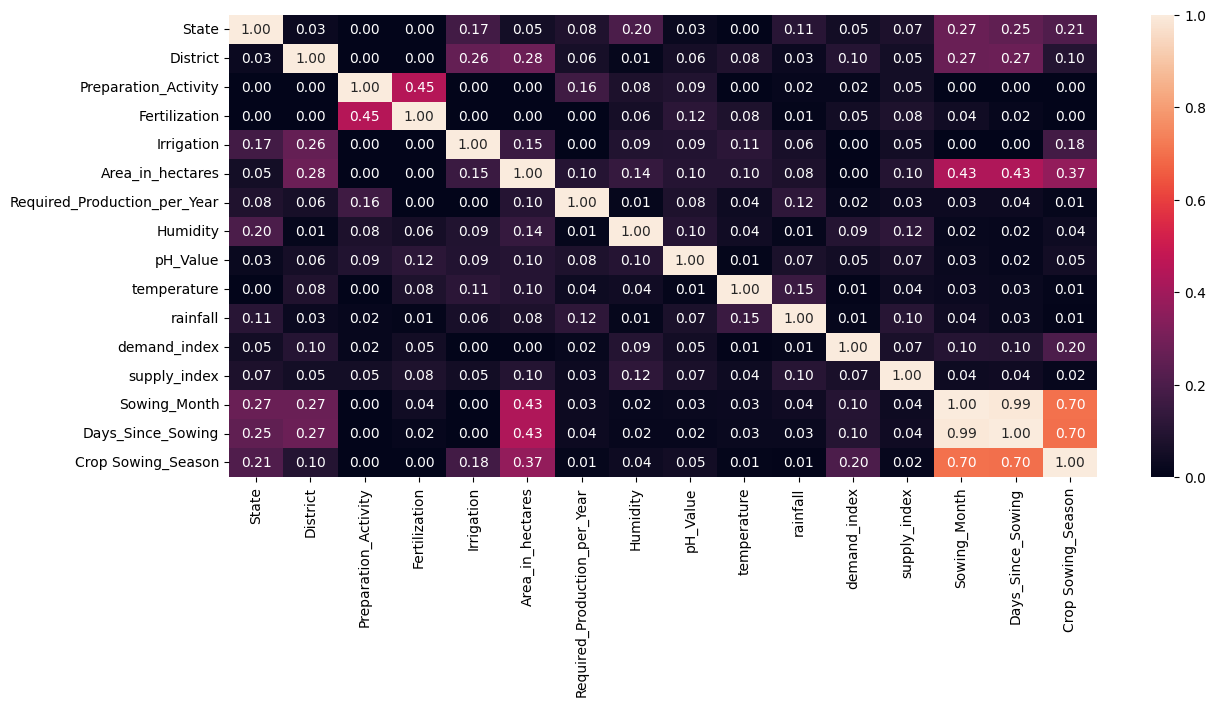

In [136]:
plt.figure(figsize=(14,6))
sns.heatmap(corr_matrix, annot=True, fmt = ".2f")
plt.show()

In [137]:
#The simplest way to remove highly correlated features is to drop one of the highly correlated features with another. 
# We can do this using the Pandas drop() method.
# get upper triangle of correlation matrix
up = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool_))

In [138]:
# find features with correlation greater than 0.90
to_drop = [column for column in up.columns if any(up[column] > 0.90)]
to_drop

['Days_Since_Sowing']

In [139]:
# drop highly correlated features
X.drop(to_drop, axis=1, inplace=True)

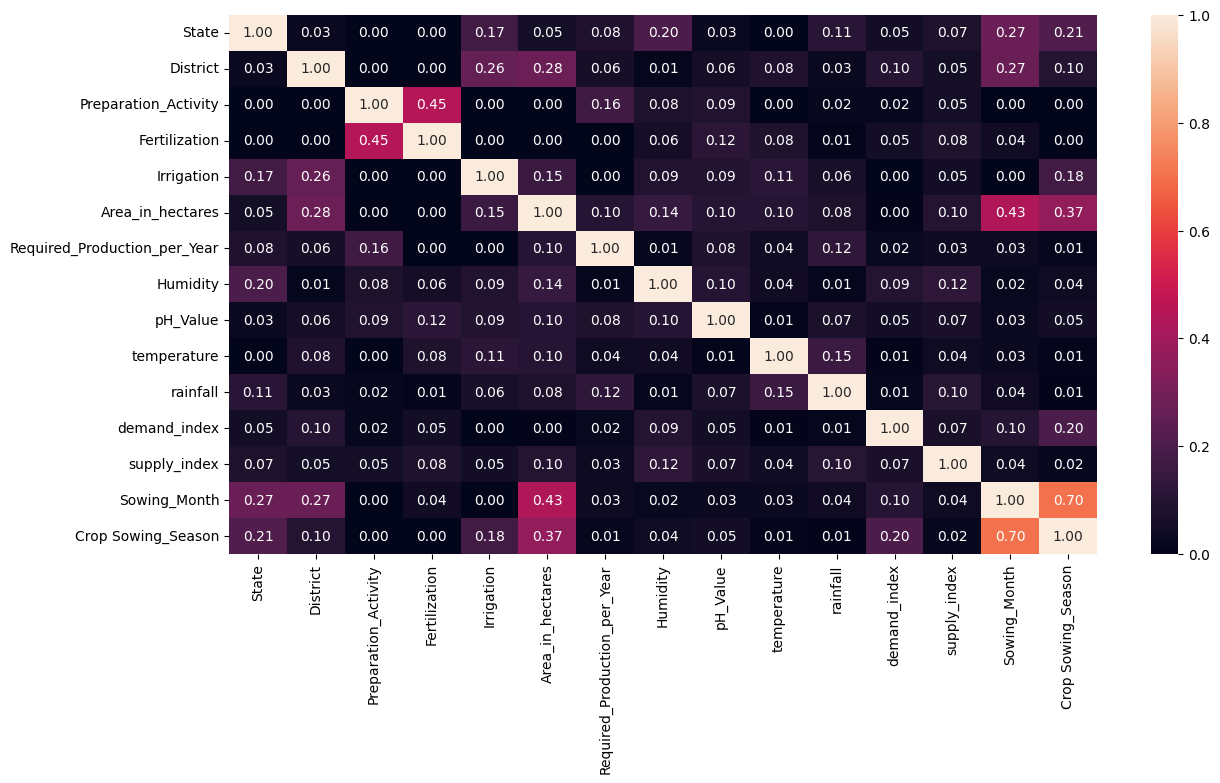

In [140]:
plt.figure(figsize=(14, 7))
sns.heatmap(X.corr().abs(), annot=True, fmt = ".2f")
plt.show()

In [141]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Features"] = X.columns
vif

,VIF_Factor,Features
0,4.061421,State
1,4.951525,District
2,3.500417,Preparation_Activity
3,2.625388,Fertilization
4,4.146670,Irrigation
5,21.789179,Area_in_hectares
6,91.276203,Required_Production_per_Year
7,6.532686,Humidity
8,11.658785,pH_Value
9,7.815494,temperature


In [142]:
X.shape

(132, 15)

##### Scalling the features

In [145]:
ss = StandardScaler()
X = ss.fit_transform(X)
type(y)

numpy.ndarray

In [146]:
X[:1]

array([[-0.21473125, -1.47029409, -0.4472136 ,  1.        ,  0.76088591,
        -2.27851196,  0.09949019, -0.73986073,  0.29295448,  1.17488869,
        -1.75129868,  1.37037509,  1.09801614, -0.96216802,  1.14003931,
        -0.5652526 ]])

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=122)

#### Model Building

##### Define function for all models at once

In [158]:
models = {"svr": SVR(), 
          "randomforestR": RandomForestRegressor(random_state=12), 
          "gbr": GradientBoostingRegressor(random_state=145), 
          "abr": AdaBoostRegressor(random_state=144), 
          "lr": LinearRegression(), 
          "dtr": DecisionTreeRegressor(random_state=124)}

In [159]:
def model_building(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    for m in models.values():
        m.fit(X_train, y_train)
        y_pred = m.predict(X_test)
        # Evaluate the model
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        print(f"\n{m}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
        print(f"R² Score: {r2:.2f}")
        print(f"Mean Absolute Error (MAE): {mae:.2f}")
        df = pd.DataFrame([y_pred, y_test]).T
    

In [160]:
model_building(X, y)


SVR()
Root Mean Squared Error (RMSE): 1.88
R² Score: 0.02
Mean Absolute Error (MAE): 1.57

RandomForestRegressor(random_state=12)
Root Mean Squared Error (RMSE): 1.90
R² Score: 0.01
Mean Absolute Error (MAE): 1.53

GradientBoostingRegressor(random_state=145)
Root Mean Squared Error (RMSE): 1.77
R² Score: 0.13
Mean Absolute Error (MAE): 1.49

AdaBoostRegressor(random_state=144)
Root Mean Squared Error (RMSE): 1.80
R² Score: 0.11
Mean Absolute Error (MAE): 1.42

LinearRegression()
Root Mean Squared Error (RMSE): 2.11
R² Score: -0.23
Mean Absolute Error (MAE): 1.72

DecisionTreeRegressor(random_state=124)
Root Mean Squared Error (RMSE): 2.08
R² Score: -0.20
Mean Absolute Error (MAE): 1.71


##### Individual models

##### RandomForest Regressor

In [224]:
rfr = RandomForestRegressor(n_estimators=20, max_depth=3, random_state=12)

In [225]:
# Train the model
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=20, random_state=12)

<Axes: >

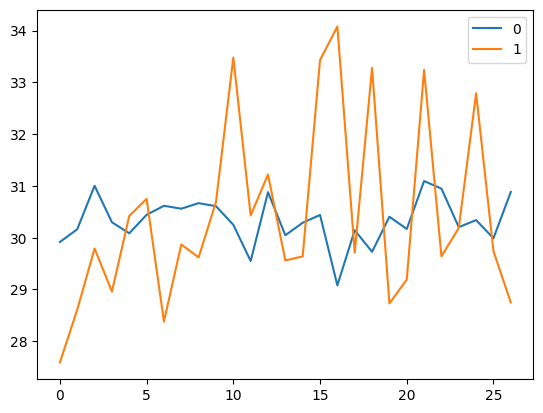

In [226]:
# Predict on the test set
rfr_pred = rfr.predict(X_test)
pd.DataFrame([rfr_pred, y_test]).T.plot()

In [227]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, rfr_pred))
r2 = r2_score(y_test, rfr_pred)
mae = mean_absolute_error(y_test, rfr_pred)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Root Mean Squared Error (RMSE): 1.90
R² Score: -0.17
Mean Absolute Error (MAE): 1.47


##### XGBoost Regressor

In [229]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgb_pred = xgb.predict(X_test)
pd.DataFrame([xgb_pred, y_test]).T

##### Gradiant Boost Regressor

In [412]:
gbr = GradientBoostingRegressor(n_estimators=10, random_state=22)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=10, random_state=22)

In [413]:
bgr_pred = gbr.predict(X_test)
pd.DataFrame([bgr_pred, y_test]).T.head()

,0,1
0,30.457472,27.59
1,30.331503,28.61
2,30.604792,29.79
3,29.874910,28.96
4,30.542485,30.42


<Axes: >

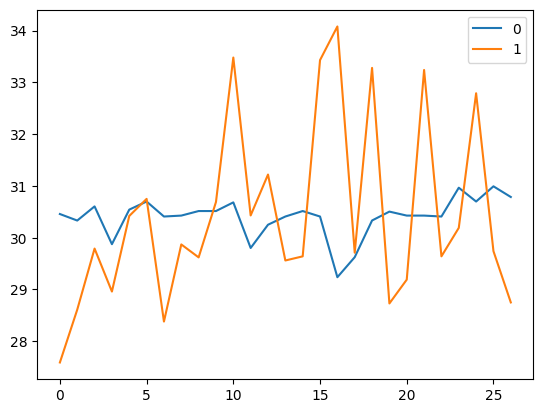

In [414]:
pd.DataFrame([bgr_pred, y_test]).T.plot()

In [422]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, bgr_pred))
r2 = r2_score(y_test, bgr_pred)
mae = mean_absolute_error(y_test, bgr_pred)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Root Mean Squared Error (RMSE): 1.86
R² Score: -0.12
Mean Absolute Error (MAE): 1.48


##### Linear Regressor

In [415]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
df = pd.DataFrame([lr_pred, y_test]).T
df.head()

,0,1
0,29.916660,27.59
1,30.690830,28.61
2,31.118294,29.79
3,29.746694,28.96
4,30.906336,30.42


<Axes: >

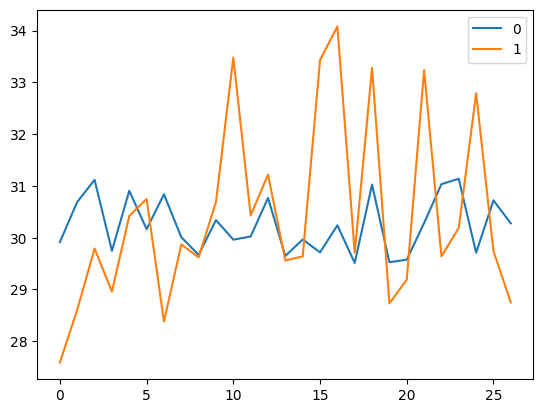

In [423]:
df.plot()

In [424]:
# The coefficients
print("Coefficients: \n", lr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, lr_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, lr_pred))

Coefficients: 
 [-0.27966031 -0.1869746   0.02243131  0.14353707 -0.06400427  0.18257385
  0.25274039 -0.28813458 -0.11659832 -0.10877255 -0.26683826 -0.11631922
 -0.08441382  0.30823402 -0.06881108]
Mean squared error: 3.35
Coefficient of determination: -0.09


##### Support Vector Regressor

<Axes: >

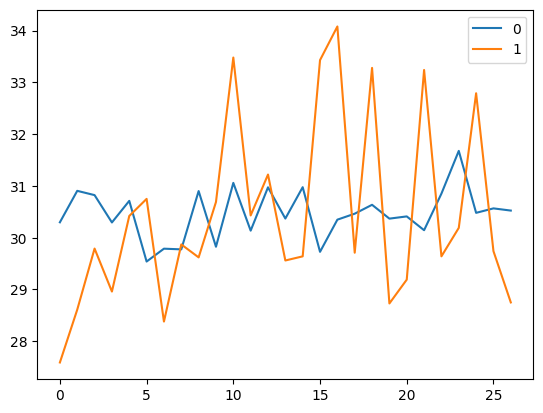

In [425]:
svm = SVR()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
pd.DataFrame([svm_pred, y_test]).T.plot()

In [426]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, svm_pred))
r2 = r2_score(y_test, svm_pred)
mae = mean_absolute_error(y_test, svm_pred)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Root Mean Squared Error (RMSE): 1.84
R² Score: -0.10
Mean Absolute Error (MAE): 1.56


#### Hyper-parameter Tuning

In [806]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}



In [812]:
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv = 5)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 7],
                         'n_estimators': [100, 200, 300]})

<Axes: >

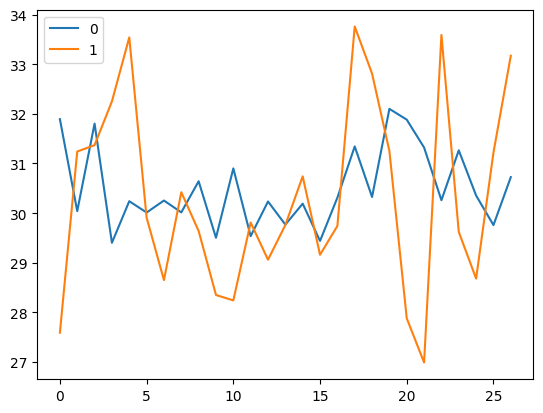

In [813]:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
pd.DataFrame([y_pred_best, y_test]).T.plot()
# y_pred_best
# y_test

In [75]:

# Evaluate the best model
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)

print("\nAfter Hyperparameter Tuning:")
print(f"Best Model RMSE: {rmse_best:.2f}")
print(f"Best Model R² Score: {r2_best:.2f}")
print(f"Best Model MAE: {mae_best:.2f}")



After Hyperparameter Tuning:
Best Model RMSE: 2.08
Best Model R² Score: -0.19
Best Model MAE: 1.68
